In [1]:
import os
import numpy as np
import yaml
import pandas as pd
import textwrap

In [2]:
import matplotlib.pyplot as plt 

In [3]:
plt.rcParams['font.family']='Roboto'
plt.rcParams['font.size']=9

In [4]:
# plt.rcParams['text.usetex']=True
# plt.rcParams['font.family']='serif'
# # plt.rcParams['font.size']=9
# # plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
# # plt.rcParams['figure.figsize']=(6.8,4)
# plt.rcParams['text.latex.preamble']=r'\usepackage{amsmath,amssymb,physics,bm,color}'

Simple Functions

In [5]:
def get_yaml_data_from_arxiv_number(arxiv_number):
    with open(os.path.join('..', f'{arxiv_number}', f'{arxiv_number}.yaml'), 'r') as f:
        return yaml.safe_load(f)

In [6]:
with open('../prompt_classification.yaml', 'r') as f:
    prompt_classification = yaml.safe_load(f)

In [7]:
with open('../Task_type.yaml', 'r') as f:
    task_type = yaml.safe_load(f)

In [8]:
def placeholder():
    with open('../Placeholder_name.yaml', 'r') as f:
        return yaml.safe_load(f)

In [9]:
placeholder()

{'site i and site j with the interaction strength': 'form of interaction',
 'site i and site j with the amplitude hopping': 'form of hopping',
 'int_form': 'interaction q-dependence',
 'system': 'system identity',
 'degrees_of_freedom': 'flavor',
 'definition_of_variables': 'definition of variables',
 'parabolic|Dirac|cos': 'type of dispersion',
 'Energy_dispersion': 'dispersion',
 'electrons|holes': 'type of particles',
 '$r$|$k$': 'Fourier transform from real or momentum space',
 'You should ensure the hermiticity of the Hamiltonian': 'hermiticity of the Hamiltonian',
 'entire_real|first_Brillouin_Zone': 'integration region of momentum',
 'bilinear_op': 'order parameter',
 'real_creation_op': 'position space creation operator',
 'momentum_creation_op': 'momentum space creation operator',
 'annihilation_op': 'annihilation operator',
 'definition_of_Fourier_Transformation': 'Fourier transform of second-quantized operator',
 'momentum_var': 'momentum',
 'real_variable': 'position',
 'si

In [10]:
is_ambigous_dict = {}
for task in prompt_classification:
    if task['task'] not in is_ambigous_dict:
        if 'placeholder' in task:
            is_ambigous_dict[task['task']] = [key for key,val in task['placeholder'].items() if val == 'A']

# Dataset

In [11]:
arxiv_number_list = [
    "1010.1819",
    "1106.6060",
    "1208.0116",
    # "1212.5363", # TODO
    "1310.2674",
    "1508.00296",
    "1812.04213",
    "2004.04168",
    "2008.08998",
    "2012.04554",
    "2108.02159",
    "2110.11330",
    "2111.01152",
    "2112.07523",
    "2308.03843",
    "2308.07488",
]


def get_branch_from_arxiv_number(arxiv_number):
    yaml_data = get_yaml_data_from_arxiv_number(arxiv_number=arxiv_number)
    return yaml_data[0]["branch"]


# Keeps the pd.Series nicely ordered from the start
arxiv_number_list.sort(key=get_branch_from_arxiv_number)

# Construct List of Tuple Indices and Data

In [12]:
tuple_index_list = []
score_list = []
unscored_set=set()

for arxiv_number in arxiv_number_list:
    yaml_data = get_yaml_data_from_arxiv_number(arxiv_number)

    # Branch name
    cur_branch_name = yaml_data[0]["branch"]

    # Arxiv number
    cur_arxiv_number = arxiv_number

    for task_dict in yaml_data[1:]:
        # Task name
        cur_task_name = task_dict["task"]
        cur_task_type=task_type[cur_task_name]

        for placeholder_name, placeholder_data in task_dict["placeholder"].items():
            # Placeholder name
            cur_placeholder_name = placeholder_name
            is_ambiguous = cur_placeholder_name in is_ambigous_dict.get(cur_task_name, [])

            if "score" in placeholder_data:  # Some entries in tasks don't have a score
                for scorer, score in placeholder_data["score"].items():
                    if scorer in ["Haining","Yasaman"]:
                        cur_scorer = scorer

                        tuple_index_list.append(
                            (
                                cur_branch_name,
                                cur_arxiv_number,
                                cur_task_name,
                                cur_task_type,
                                cur_placeholder_name,
                                is_ambiguous,
                                cur_scorer,
                            )
                        )
                    
                        if score is None:
                            cur_score = '(TODO)'
                            # print((cur_arxiv_number,cur_task_name,cur_placeholder_name,cur_scorer))
                        else:
                            cur_score = score
                        score_list.append(cur_score)
            else:
                unscored_set.add(placeholder_name)

In [13]:
len(unscored_set)

26

# Create Pandas Series using MultiIndex

In [14]:
index = pd.MultiIndex.from_tuples(tuple_index_list, names=['branch', 'arxiv', 'task','task_type','placeholder', 'is_ambiguous','scorer',])
data = pd.DataFrame({'Score': score_list}, index=index)
data['Score']=pd.to_numeric(data['Score'],errors='coerce')

In [15]:
def remove(df,level='task', tasks_to_exclude=["Combine the Hartree and Fock term", ]):
    mask = df.index.get_level_values('task').isin(tasks_to_exclude)
    rows_to_keep = ~mask
    df_filtered = df[rows_to_keep]
    df_dropped = df.drop(labels=tasks_to_exclude, level=level)
    return df_dropped


In [16]:
data = remove(data)

In [16]:
data.to_pickle('reading_data.pickle')

In [17]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Average score')

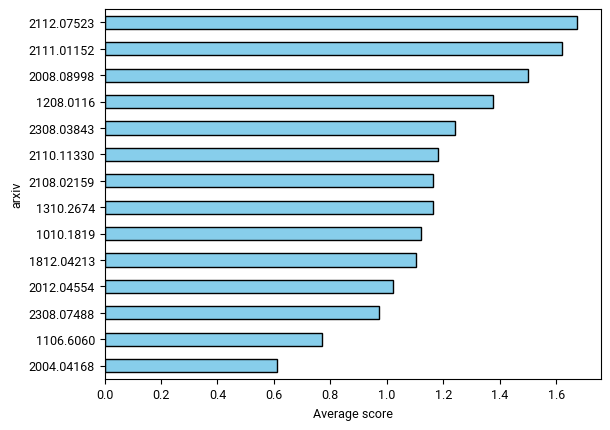

In [18]:
data_value_sort=data.xs(key='Haining',level='scorer').groupby('arxiv').mean().sort_values(by='Score')
data_value_sort.plot(kind='barh',color='skyblue',edgecolor='k',legend=False)
plt.xlabel('Average score')

In [78]:
data.groupby('branch').count()

,Score
branch,
"continuum, first-quantized",538
"continuum, second-quantized",220
"lattice, second-quantized",705


In [77]:
len(set(data.xs(key='continuum, first-quantized',level='branch').index.get_level_values('placeholder').unique())-set(symbols))

45

In [79]:
len(set(data.xs(key='continuum, second-quantized',level='branch').index.get_level_values('placeholder').unique())-set(symbols))

32

In [80]:
len(set(data.xs(key='lattice, second-quantized',level='branch').index.get_level_values('placeholder').unique())-set(symbols))

42

# Compare different tasks

In [17]:
reading_literally=["definition_of_variables",'degrees_of_freedom','diagonal_potential','offdiagonal_potential','normalization_factor','int_form','interaction','potential_degrees_of_freedom','parabolic|Dirac|cos','site i and site j with the amplitude hopping','site i and site j with the interaction strength','system']
reading_with_inferring=["$r$|$k$","Energy_dispersion","For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$","Ham_op","Note that hopping have no position dependence now.",'Note that interaction have no position dependence now','Note that the sublattice degrees of freedom is suppressed for now and will be stated later','Potential_variables','Unsummed_Indices','You should ensure the hermiticity of the Hamiltonian','electrons|holes','entire_real|first_Brillouin_Zone','entire_space|first_Brillouin_zone','real|momentum','single-particle|second-quantized','order','variable','shifted_Ek','relabel','op','k|r','momentum_shift','momentum','index_of_operator','index_1','index_2','expression_offdiag','expression_diag','expression_Hartree_1','expression_Hartree_2','expected_value_nonzero','expected_value','expected_value_Hartree','In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.',]
background_knowledge=['annihilation_op','bilinear_op','creation_op','definition_of_Fourier_Transformation','hole_annihilation_op','hole_creation_op','hole_op','particle_op','momentum_creation_op','real_creation_op','particle_annihilation_op','particle_creation_op',]
symbols=['kinetic_symbol',
 'k_symbol',
 'r_symbol',
 'nonint_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'matrix_element_symbol',
 'basis_symbol',
 'second_int_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'Hartree_Fock_second_quantized_symbol',
 'Hartree_second_quantized_symbol',
 'Fock_second_quantized_symbol',
 'dispersion_symbol',
 'density_symbol',
 'momentum_var',
 'real_variable']

In [18]:
len(background_knowledge)

12

In [20]:
len(symbols)

18

In [21]:
len(set(symbols))-len(symbols)

0

In [22]:
occurrence=data.index.get_level_values('placeholder').value_counts().to_dict()

In [23]:
reading_literally_sorted=sorted(reading_literally,key=occurrence.get,reverse=True)
for key in reading_literally_sorted:
    print(f'{key}:{occurrence[key]}')
reading_literally_compare_list=reading_literally_sorted
reading_literally_compare_list=['system','degrees_of_freedom','definition_of_variables','site i and site j with the amplitude hopping','parabolic|Dirac|cos','site i and site j with the interaction strength','int_form',]

definition_of_variables:190
degrees_of_freedom:46
system:30
site i and site j with the amplitude hopping:16
site i and site j with the interaction strength:16
normalization_factor:14
int_form:14
interaction:14
parabolic|Dirac|cos:14
diagonal_potential:8
offdiagonal_potential:8
potential_degrees_of_freedom:8


In [24]:
reading_literally_compare_list

['system',
 'degrees_of_freedom',
 'definition_of_variables',
 'site i and site j with the amplitude hopping',
 'parabolic|Dirac|cos',
 'site i and site j with the interaction strength',
 'int_form']

In [25]:
reading_with_inferring_sorted=sorted(reading_with_inferring,key=occurrence.get,reverse=True)
for key in reading_with_inferring_sorted:
    print(f'{key}:{occurrence[key]}')
# reading_with_inferring_compare_list=['single-particle|second-quantized','real|momentum','Energy_dispersion','electrons|holes','Unsummed_Indices','$r$|$k$','entire_real|first_Brillouin_Zone','entire_space|first_Brillouin_zone']
reading_with_inferring_compare_list=['electrons|holes','Energy_dispersion','entire_real|first_Brillouin_Zone','$r$|$k$','You should ensure the hermiticity of the Hamiltonian']

expected_value:62
single-particle|second-quantized:54
real|momentum:46
momentum:34
expected_value_nonzero:34
expression_Hartree_1:28
expression_Hartree_2:28
Note that hopping have no position dependence now.:16
Note that interaction have no position dependence now:16
You should ensure the hermiticity of the Hamiltonian:16
op:16
Energy_dispersion:14
For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$:14
Unsummed_Indices:14
electrons|holes:14
shifted_Ek:14
relabel:14
momentum_shift:14
index_of_operator:14
In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.:14
Note that the sublattice degrees of freedom is suppressed for now and will be stated later:10
order:10
variable:10
$r$|$k$:8
Potential_variables:8
expression_offdiag:8
expression_diag:8
entire_real|first_Brillouin_Zone:4
entire_space|first_Brillouin_zone:4
k|r:4
expected_value_Hartree:4
Ham_op:2
index_1:2
index_2:

In [28]:
# reading_with_inferring_compare_list=['single-particle|second-quantized','real|momentum','Energy_dispersion','electrons|holes','Unsummed_Indices','$r$|$k$','entire_real|first_Brillouin_Zone','entire_space|first_Brillouin_zone']

In [26]:
background_knowledge_sorted=sorted(background_knowledge,key=occurrence.get,reverse=True)
for key in background_knowledge_sorted:
    print(f'{key}:{occurrence[key]}')
background_knowledge_compare_list=background_knowledge_sorted[:5]

background_knowledge_compare_list=['bilinear_op','annihilation_op','real_creation_op','momentum_creation_op','definition_of_Fourier_Transformation']

definition_of_Fourier_Transformation:36
momentum_creation_op:36
real_creation_op:36
bilinear_op:30
annihilation_op:4
creation_op:4
hole_op:4
hole_annihilation_op:2
hole_creation_op:2
particle_op:2
particle_annihilation_op:2
particle_creation_op:2


In [27]:
symbols_sorted=sorted(symbols,key=occurrence.get,reverse=True)
for key in symbols_sorted:
    print(f'{key}:{occurrence[key]}')
symbols_compare_list=symbols_sorted[:10]
symbols_compare_list=['k_symbol','r_symbol','kinetic_symbol','potential_symbol','nonint_symbol','second_int_symbol','Hartree_Fock_symbol',]

Hartree_Fock_second_quantized_symbol:82
second_int_symbol:76
kinetic_symbol:68
real_variable:36
Hartree_Fock_symbol:30
Hartree_Fock_term_symbol:30
nonint_symbol:24
potential_symbol:24
second_nonint_symbol:24
Hartree_second_quantized_symbol:23
density_symbol:16
momentum_var:16
Fock_second_quantized_symbol:15
k_symbol:14
r_symbol:14
matrix_element_symbol:8
basis_symbol:8
dispersion_symbol:4


In [28]:
compare_list=['real|momentum','single-particle|second-quantized','degrees_of_freedom','definition_of_variables','definition_of_Fourier_Transformation','system','parabolic|Dirac|cos',]

In [29]:
[index for index in data.index.get_level_values('placeholder').unique() if 'symbol' in index]

['kinetic_symbol',
 'k_symbol',
 'r_symbol',
 'In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.',
 'nonint_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'matrix_element_symbol',
 'basis_symbol',
 'second_int_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'Hartree_Fock_second_quantized_symbol',
 'Hartree_second_quantized_symbol',
 'Fock_second_quantized_symbol',
 'dispersion_symbol',
 'density_symbol']

In [30]:
original_ph=list(data.index.get_level_values('placeholder').unique())+list(unscored_set)
slash_underscore_ph=[ph.replace('_',r'\_') for ph in original_ph]
replace_underscore=''
for origin, slash in zip(original_ph,slash_underscore_ph):
    replace_underscore+=f'{origin}: {slash}\n'
with open('../underscore_replace_placeholder.yaml','w') as f:
    f.write(replace_underscore)

In [31]:
['Note that hopping have no' in category for category in [symbols,background_knowledge,reading_with_inferring,reading_literally]]

[False, False, False, False]

In [32]:
set(data.index.get_level_values('placeholder').unique())-set(symbols)-set(background_knowledge)-set(reading_with_inferring)-set(reading_literally)

set()

## Comparing results

### Reading ability

In [33]:
data_groupby=data.groupby('placeholder').agg(['mean','sem','count'])

In [35]:
data_groupby.loc[reading_literally_compare_list]

Score                
                                                     mean       sem count
placeholder                                                              
system                                           1.750000  0.121988    28
degrees_of_freedom                               1.523810  0.109046    42
definition_of_variables                          1.638889  0.049682   180
site i and site j with the amplitude hopping     1.571429  0.227608    14
parabolic|Dirac|cos                              1.428571  0.250588    14
site i and site j with the interaction strength  1.714286  0.125294    14
int_form                                         1.285714  0.244243    14

In [36]:
def plot_bar(compare_list,complete_list,df_groupby,title,color,width=25,yticklabel=None):
    df_0=df_groupby.loc[compare_list]['Score']
    
    ax=df_0['mean'].plot(kind='barh',color=color,edgecolor='k',xerr=df_0['sem'],legend=False,figsize=(4, 4),capsize=2,)
    ax.grid(axis='x',ls='--')
    if yticklabel is None:
        ax.set_yticklabels(['\n'.join(textwrap.wrap(placeholder()[task] if task in placeholder() else task, width=width)) for task in df_0.index],fontsize=9)
    else:
        ax.set_yticklabels([name+'\n'+symbol+' '+arxiv for task,(name, symbol,arxiv) in zip(df_0.index, yticklabel)],fontsize=9)
    ax.set_ylabel('')
    ax.set_xlabel('Score')
    # ax.set_title(f'{title} \n[mean={df_groupby.loc[complete_list]["Score"]["mean"].mean():.2f}]')
    ax.set_xlim(0,2.1)
    return ax

In [37]:
examples=[('HF term','$\hat{\mathcal{H}}_{\\rm{HF}}$',''),
('interacting term',' $\hat{\mathcal{H}}_{\\rm{int}}$',''),
('noninteracting term','$\hat{\mathcal{H}}_0$',''),
('potential term','$\Delta(\mathbf{r})$',',*'),
('kinetic term','$T$',',*'),
('position','$\mathbf{r}$',''),
('momentum','$\mathbf{k}$',''),
]

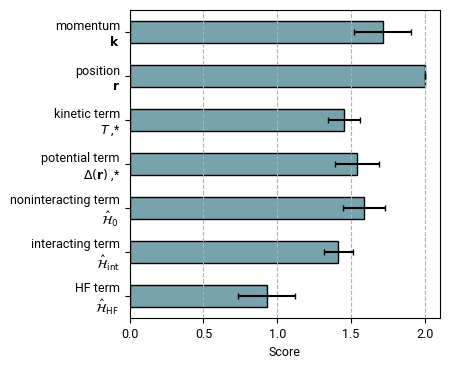

In [38]:
ax=plot_bar(symbols_compare_list[::-1], symbols,data_groupby, '',yticklabel=examples,width=25,color='#78A2AC')
# Concept $\leftrightarrow$ Notation
ax.get_figure().savefig('4e.pdf',bbox_inches='tight')

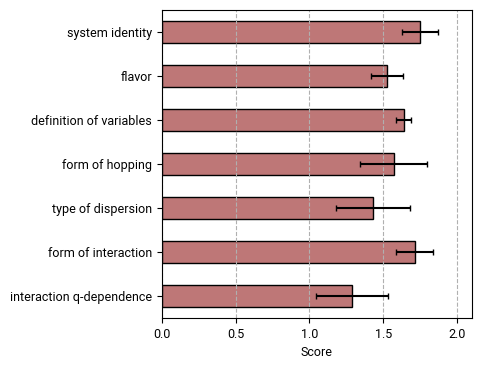

In [39]:
ax=plot_bar(reading_literally_compare_list[::-1], reading_literally, data_groupby, '',color='#BE7777')
# Isolated information
ax.get_figure().savefig('4f.pdf',bbox_inches='tight')

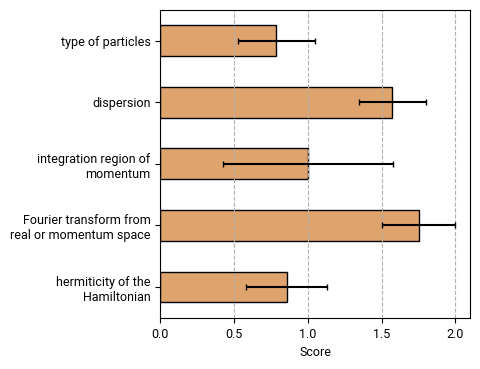

In [40]:
ax=plot_bar(reading_with_inferring_compare_list[::-1], reading_with_inferring, data_groupby, '',color='#DFA36D')
# Scattered Information 
ax.get_figure().savefig('4g.pdf',bbox_inches='tight')

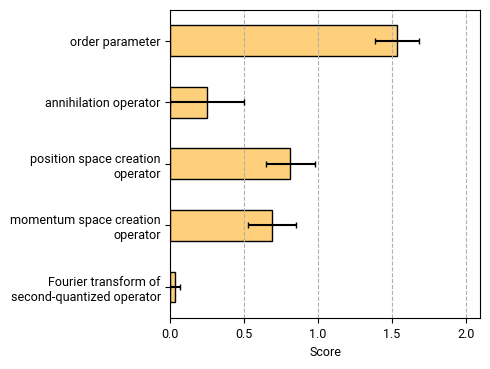

In [41]:
ax=plot_bar(background_knowledge_compare_list[::-1], background_knowledge,data_groupby, '',color='#FED07B')
# Information + Knowledge
# ax.get_figure().savefig('4h.pdf',bbox_inches='tight')

In [164]:
["single-particle|second-quantized" in s for s in (symbols,reading_literally,reading_with_inferring,background_knowledge)]

[False, False, True, False]

In [152]:
"momentum_var" in data.index.get_level_values('placeholder').unique()

True

# Score by task

In [42]:
with open('../Naming.yaml','r') as f:
    naming=yaml.safe_load(f)

In [43]:
data_groupby_task=data.groupby('task').agg(['mean','sem','count'])


In [44]:
data_groupby_task_common=data_groupby_task[data_groupby_task['Score']['count']>=28].sort_values(by=('Score','mean'),)


(0.0, 2.1)

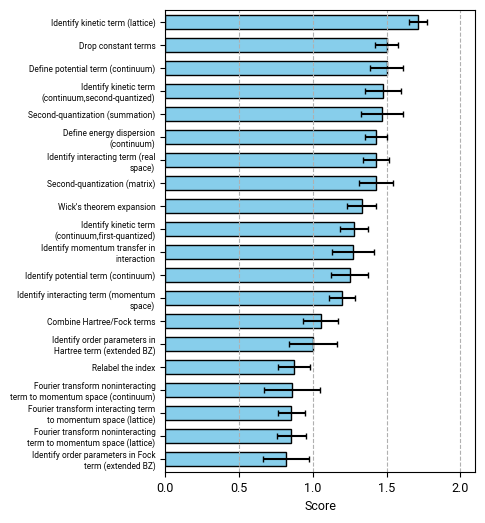

In [45]:
ax=data_groupby_task_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_groupby_task_common['Score']['sem'],legend=False,figsize=(4, 6),capsize=2,width=0.6)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(naming[task], width=35)) for task in data_groupby_task_common['Score']['mean'].index],fontsize=6)
# ax.set_title('Score of information extraction by tasks')
ax.set_xlim(0,2.1)

# Score by task type

In [46]:
task_type_order=[r'$H=H_0+H_{\rm{int}}$','FT',"Wick's theorem",r'$H_{\rm{HF}}$','OP']
# step_color_list=['#a2d2ff','#bde0fe','#ffafcc','#ffc8dd','#cdb4db']
step_color_list=['#e9dfb3','#bbcdd1','#f3b1b1','#ccda8d','#facfa8']

In [47]:
data_groupby_task_type=data.groupby('task_type').agg(['mean','sem','count'])
data_groupby_task_type=data_groupby_task_type.loc[task_type_order[::-1]]

In [48]:
data_groupby_task_type_common=data_groupby_task_type[data_groupby_task_type['Score']['count']>=28]

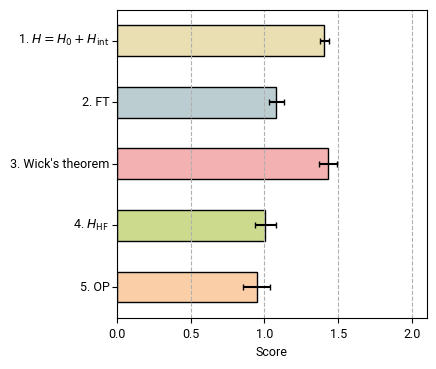

In [49]:
ax=data_groupby_task_type_common['Score']['mean'].plot(kind='barh',color=step_color_list[::-1],edgecolor='k',xerr=data_groupby_task_type_common['Score']['sem'],legend=False,figsize=(4, 4),capsize=2,)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
# ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=15)) for task in data_groupby_task_type_common['Score']['mean'].index],fontsize=7)
ax.set_yticklabels([])
[ax.text(-0.05,idx,str(5-idx)+'. '+task,ha='right',va='center',) for idx,task in enumerate(data_groupby_task_type_common['Score']['mean'].index)]
# ax.set_title('Scores of information extraction by steps')
ax.set_xlim(0,2.1)
ax.get_figure().savefig('4c.pdf',bbox_inches='tight')

# Score by branch

In [50]:
data_groupby_branch=data.groupby('branch').agg(['mean','sem','count'])

(0.0, 2.1)

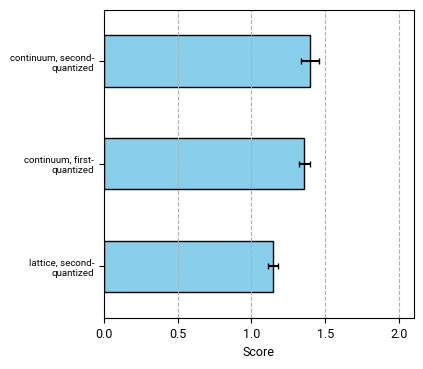

In [51]:
ax=data_groupby_branch['Score']['mean'].sort_values().plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_groupby_branch['Score']['sem'],legend=False,figsize=(4, 4),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=20)) for task in data_groupby_branch['Score']['mean'].sort_values().index],fontsize=7)
# ax.set_title('Score of information extraction by branches')
ax.set_xlim(0,2.1)

# Score by ambiguity (Leave for now)

In [45]:
data_groupby_ambi=data.groupby('is_ambiguous').agg(['mean','sem','count'])

In [46]:
data_am_groupby_ph=data.xs(key=True,level='is_ambiguous').groupby('placeholder').agg(['mean','sem','count'])
data_unam_groupby_ph=data.xs(key=False,level='is_ambiguous').groupby('placeholder').agg(['mean','sem','count'])
data_am_group_ph_common=data_am_groupby_ph[data_am_groupby_ph['Score']['count']>=10].sort_values(by=('Score','mean'))
data_unam_group_ph_common=data_unam_groupby_ph[data_unam_groupby_ph['Score']['count']>=10].sort_values(by=('Score','mean'))

Text(0.5, 1.0, 'Ambiguous (mean=1.19$\\pm$0.21)')

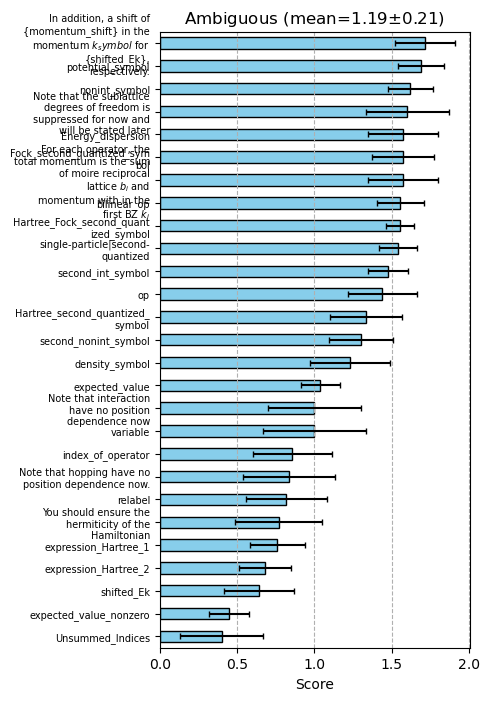

In [52]:
ax=data_am_group_ph_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_am_group_ph_common['Score']['sem'],legend=False,figsize=(4, 8),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=25)) for task in data_am_group_ph_common['Score']['mean'].index],fontsize=7)
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_title(f'Ambiguous (mean={data_am_group_ph_common["Score"]["mean"].mean():.2f}$\pm${data_am_group_ph_common["Score"]["sem"].mean():.2f})')

Text(0.5, 1.0, 'Unambiguous (mean=1.22$\\pm$0.18)')

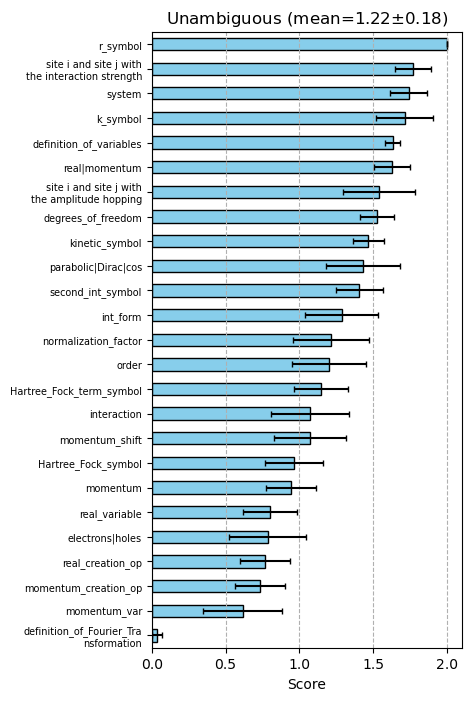

In [53]:
ax=data_unam_group_ph_common['Score']['mean'].plot(kind='barh',color='skyblue',edgecolor='k',xerr=data_unam_group_ph_common['Score']['sem'],legend=False,figsize=(4, 8),capsize=2)
ax.grid(axis='x',ls='--')
ax.set_yticklabels(['\n'.join(textwrap.wrap(task, width=25)) for task in data_unam_group_ph_common['Score']['mean'].index],fontsize=7)
ax.set_ylabel('')
ax.set_xlabel('Score')
ax.set_title(f'Unambiguous (mean={data_unam_group_ph_common["Score"]["mean"].mean():.2f}$\pm${data_unam_group_ph_common["Score"]["sem"].mean():.2f})')